<img src= "https://raw.githubusercontent.com/e-sensing/sits/master/inst/extdata/sticker/sits_sticker.png" align="left" width="64"/>
<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/logo-bdc.png" align="right" width="64" />

# <span align="center" style="color:#336699" >Improving Quality of Training Samples</span>
<hr style="border:2px solid #0077b9;">

<div style="text-align: left;">
    <a href="https://nbviewer.jupyter.org/github/brazil-data-cube/code-gallery/blob/master/jupyter/R/sits/sits-timeseries-classification.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>

<br/>

<div style="text-align: center;font-size: 90%;">
    Rolf Simoes<sup><a href="https://orcid.org/0000-0003-0953-4132"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>, Felipe Souza<sup><a href="https://orcid.org/0000-0001-7534-0219"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>, Gilberto Camara<sup><a href="https://orcid.org/0000-0001-7534-0219"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>Lorena Alves dos Santos<sup><a href="https://orcid.org/0000-0002-5826-1700"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    Earth Observation and Geoinformatics Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:brazildatacube@inpe.br">brazildatacube@inpe.br</a>
    <br/><br/>
    Last Update: September 10, 2021
</div>

<br/>

<div style="text-align: justify;  margin-left: 15%; margin-right: 15%;">
<b>Abstract.</b> SITS is an open-source R package for satellite image time series analysis. The package supports the application of machine learning techniques for classification image time series obtained from data cubes. This Jupyter notebook shows how to use self-organized maps (SOM) to improve the quality of samples used for land use classification in SITS. This notebook corresponds to the chapter "Time Series Clustering to Improve the Quality of Training Samples" in the <a href="https://e-sensing.github.io/sitsbook/" target="_blank"> book on the SITS package</a>.
</div>    

<br/>
<div style="text-align: justify;  margin-left: 15%; margin-right: 15%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>For a comprehensive sits overview and discussion, please refer to the online book:</b>
    <div style="margin-left: 10px; margin-right: 10px">
    Simoes, R; Camara, G.; Souza, F.; Santos, L.; Andrade, P.; Pelletier, C.; Carvalho, A.; Ferreira, K.; Queiroz, G. <a href="https://e-sensing.github.io/sitsbook/" target="_blank">sits: Satellite Image Time Series</a>.
    </div>
</div>

## Using self-organizing maps for sample quality control
<hr style="border:1px solid #0077b9;">

The `sits` package provides a clustering technique based on self-organizing maps (SOM). SOM is a dimensionality reduction technique, where high-dimensional data is mapped into a two dimensional map, keeping the topological relations between data patterns. A SOM 2D Map is composed by units called neurons.  When projecting a high-dimensional data set of training samples into a 2D SOM map, the neurons compete for each sample. Each time series will be mapped to one of the neurons. Since the number of neurons is smaller than the number of classes, each neuron will be associated to many time series. The resulting 2D map will be a set of clusters. Given that SOM preserves the topological structure of neighborhoods in multiple dimensions, clusters that contain training samples of a given class will usually be neighbors in 2D space. Therefore, the neighbours of each neuron of a SOM map provide information on intraclass and interclass variability which is used to detect noisy samples.

<img src="https://raw.githubusercontent.com/e-sensing/sitsbook/master/images/som_explanation.png" width="900">


## Installing sits and sitsdata packages 
<hr style="border:1px solid #0077b9;">

In [1]:
# To run the examples in this Jupyter Notebook you need to install the sits and the sitsdata R package. 
# To speed up the installation, we precompiled these packages and stored it in the notebook's data repository. 
# Installing sits
#
system("cp -u -R ../input/sits-bundle/sits-bundle/* /usr/local/lib/R/site-library/")

In [2]:
# load the sits library
library(sits)
library(sitsdata)

SITS - satellite image time series analysis.

Loaded sits v1.3.0.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.

Loaded sitsdata data sets v0.4.4. Use citation("sitsdata") for use in publication.



## Samples to be analysed
<hr style="border:1px solid #0077b9;">
The samples to be analysed in this examples are 50,160 samples of the Brazilian Cerrado biome, distributed in 13 classes. Time series are yearly data (23 samples per year) from the "MOD13Q1-6" collection of the Brazilian Data Cube. Each time series has four bands ("NIR", "MIR", "NDVI", "EVI"). 
<br/>
<br/>


<img src="https://raw.githubusercontent.com/e-sensing/sitsbook/master/images/samples_cerrado.png" width="800">



## Creating the SOM map
<hr style="border:1px solid #0077b9;">

In [3]:
# select a dataset covering the cerrado 
# there are 50,160 samples distributed in 13 classes
data("samples_cerrado_mod13q1")
sits_labels_summary(samples_cerrado_mod13q1)

label,count,prop
<chr>,<int>,<dbl>
Dense_Woodland,9966,0.198684211
Dunes,550,0.010964912
Fallow_Cotton,630,0.012559809
Millet_Cotton,316,0.006299841
Pasture,7206,0.143660287
Rocky_Savanna,8005,0.159589314
Savanna,9172,0.182854864
Savanna_Parkland,2699,0.053807815
Silviculture,423,0.008433014


In [4]:
# take only the NDVI and EVI bands
samples_cerrado_mod13q1_2bands <- sits_select(samples_cerrado_mod13q1, bands = c("NDVI", "EVI"))

In [5]:
# After selecting the samples, the new step is to run `sits_som_map()` 
# This function has six main parameters. 
# `data`:  object containing the samples. 
# `grid_xdim` and `grid_ydim`: control the size of the SOM map grid. 
# `alpha`: learning rate 
# `distance`: distance metric 
# `rlen`: number of implementations

# clustering time series using SOM
som_cluster <- sits_som_map(
  data      = samples_cerrado_mod13q1_2bands,
  grid_xdim = 15,
  grid_ydim = 15,
  alpha     = 1.0,
  distance  = "euclidean",
  rlen      = 20,
  mode      = "pbatch"
)

In [6]:
# The output of the `sits_som_map()` is a list containing:
# (1) The set of time series with two additional columns for each time series: `id_sample` and `id_neuron`.
# (2) A tibble the prior and posterior probabilities of all labels which occur in the samples assigned to each neuron. 
# (3) The SOM grid
som_cluster

$data
# A tibble: 50,160 × 9
   latitude longitude start_date end_date   label cube  time_s…¹ id_sa…² id_ne…³
      <dbl>     <dbl> <date>     <date>     <chr> <chr> <list>     <int>   <dbl>
 1    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       1     113
 2    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       2     113
 3    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       3     128
 4    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       4     114
 5    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       5      70
 6    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       6      54
 7    -16.2     -54.4 2018-09-01 2019-09-01 Past… MOD1… <tibble>       7     128
 8    -16.2     -54.5 2018-09-01 2019-09-01 Past… MOD1… <tibble>       8      54
 9    -16.1     -54.7 2018-09-01 2019-09-01 Past… MOD1… <tibble>       9     113
10    -16.2     -54.7 2018-09-01 2019-09-01 Past… MOD1… <tibble>      10      70

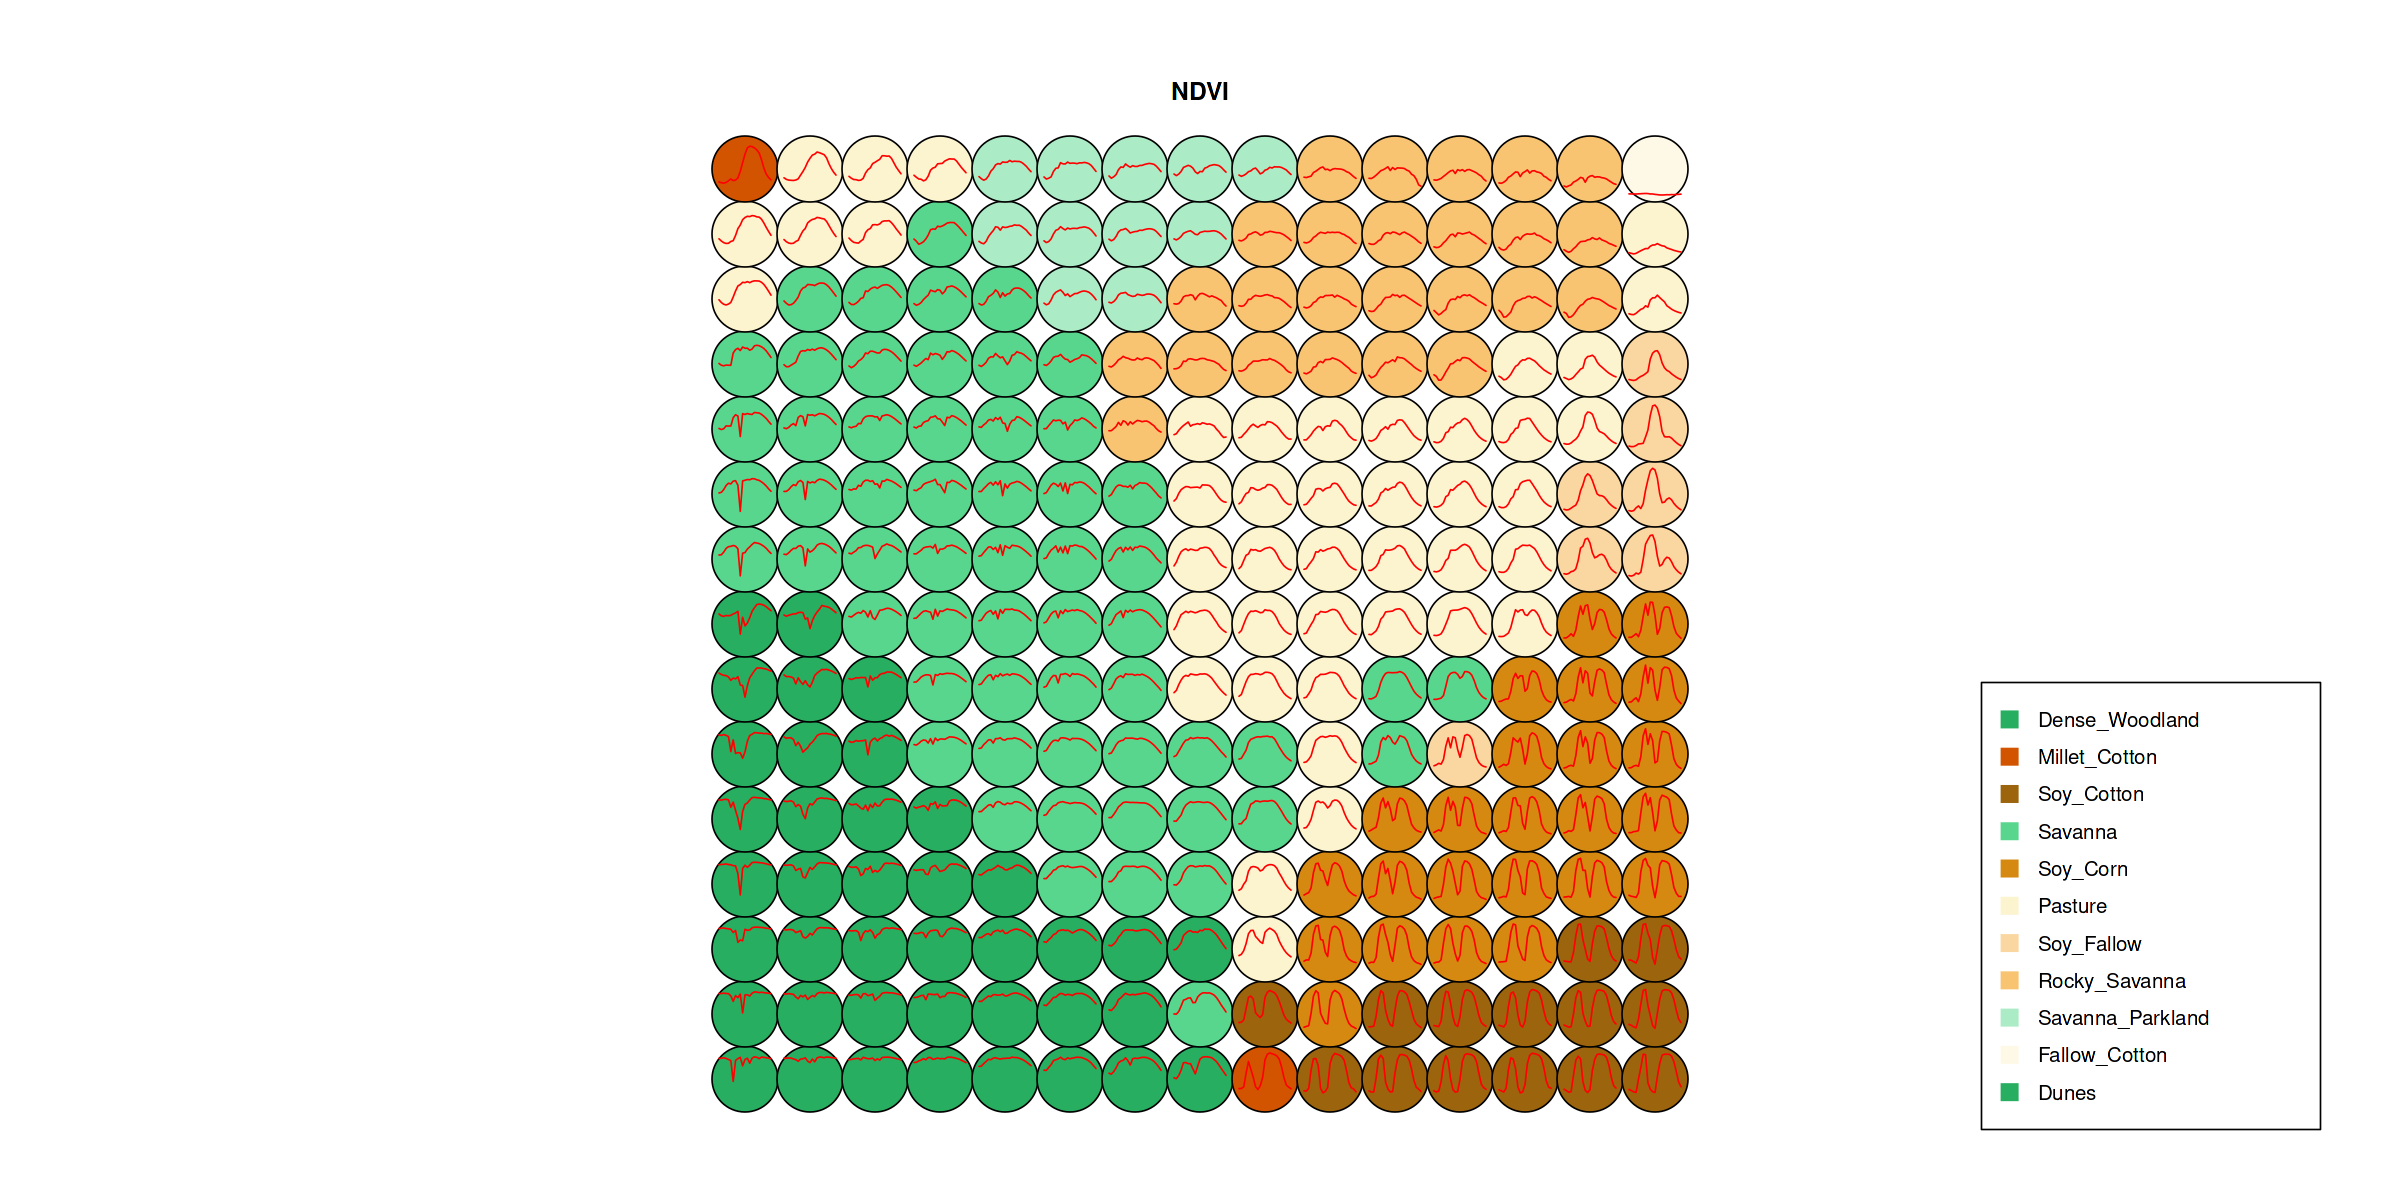

In [7]:
# To plot the SOM grid, use `plot()`. The neurons are labelled using the majority voting.
# control the output
options(repr.plot.width = 20, repr.plot.height = 10)
plot(som_cluster)

## Analysing the SOM grid
<hr style="border:1px solid #0077b9;">
The SOM grid has 225 neurons, as defined by the product of the parameters `grid_xdim` and `grid_ydim` in the `sits_som_map()`. Looking at the SOM grid, one can see that most of the neurons of a class are located close to each other, as expected. However, some "Pasture" neurons far from the main cluster. This mixture is a consequence of the continuous nature of natural vegetation cover in the Brazilian Cerrado. The transition between areas of open savanna and pasture is not always well defined; moreover, it is dependent on factors such as climate and latitude. The SOM grid provides a general view of the capacity of the samples to distinguish the chosen labels.

## Assessing confusion between labels
<hr style="border:1px solid #0077b9;">
The second step in SOM-based quality assessment is understanding the confusion between labels. The function `sits_som_evaluate_cluster()` groups neurons by their majority label and produces a tibble.  For each label, the tibble show the percentage of samples with a different label that have been mapped to a neuron whose majority is that label. 


In [8]:
# produce a tibble with a summary of the mixed labels
som_eval <- sits_som_evaluate_cluster(som_cluster)
# show the result
som_eval[1:10,]

id_cluster,cluster,class,mixture_percentage
<int>,<chr>,<chr>,<dbl>
1,Dense_Woodland,Dense_Woodland,7.955429e+01
1,Dense_Woodland,Pasture,5.130863e+00
1,Dense_Woodland,Rocky_Savanna,9.337479e+00
1,Dense_Woodland,Savanna,2.435864e+00
1,Dense_Woodland,Silviculture,3.506953e+00
1,Dense_Woodland,Soy_Corn,2.591345e-02
1,Dense_Woodland,Soy_Fallow,8.637816e-03
2,Dunes,Dunes,1.000000e+02
3,Fallow_Cotton,Fallow_Cotton,4.920949e+01


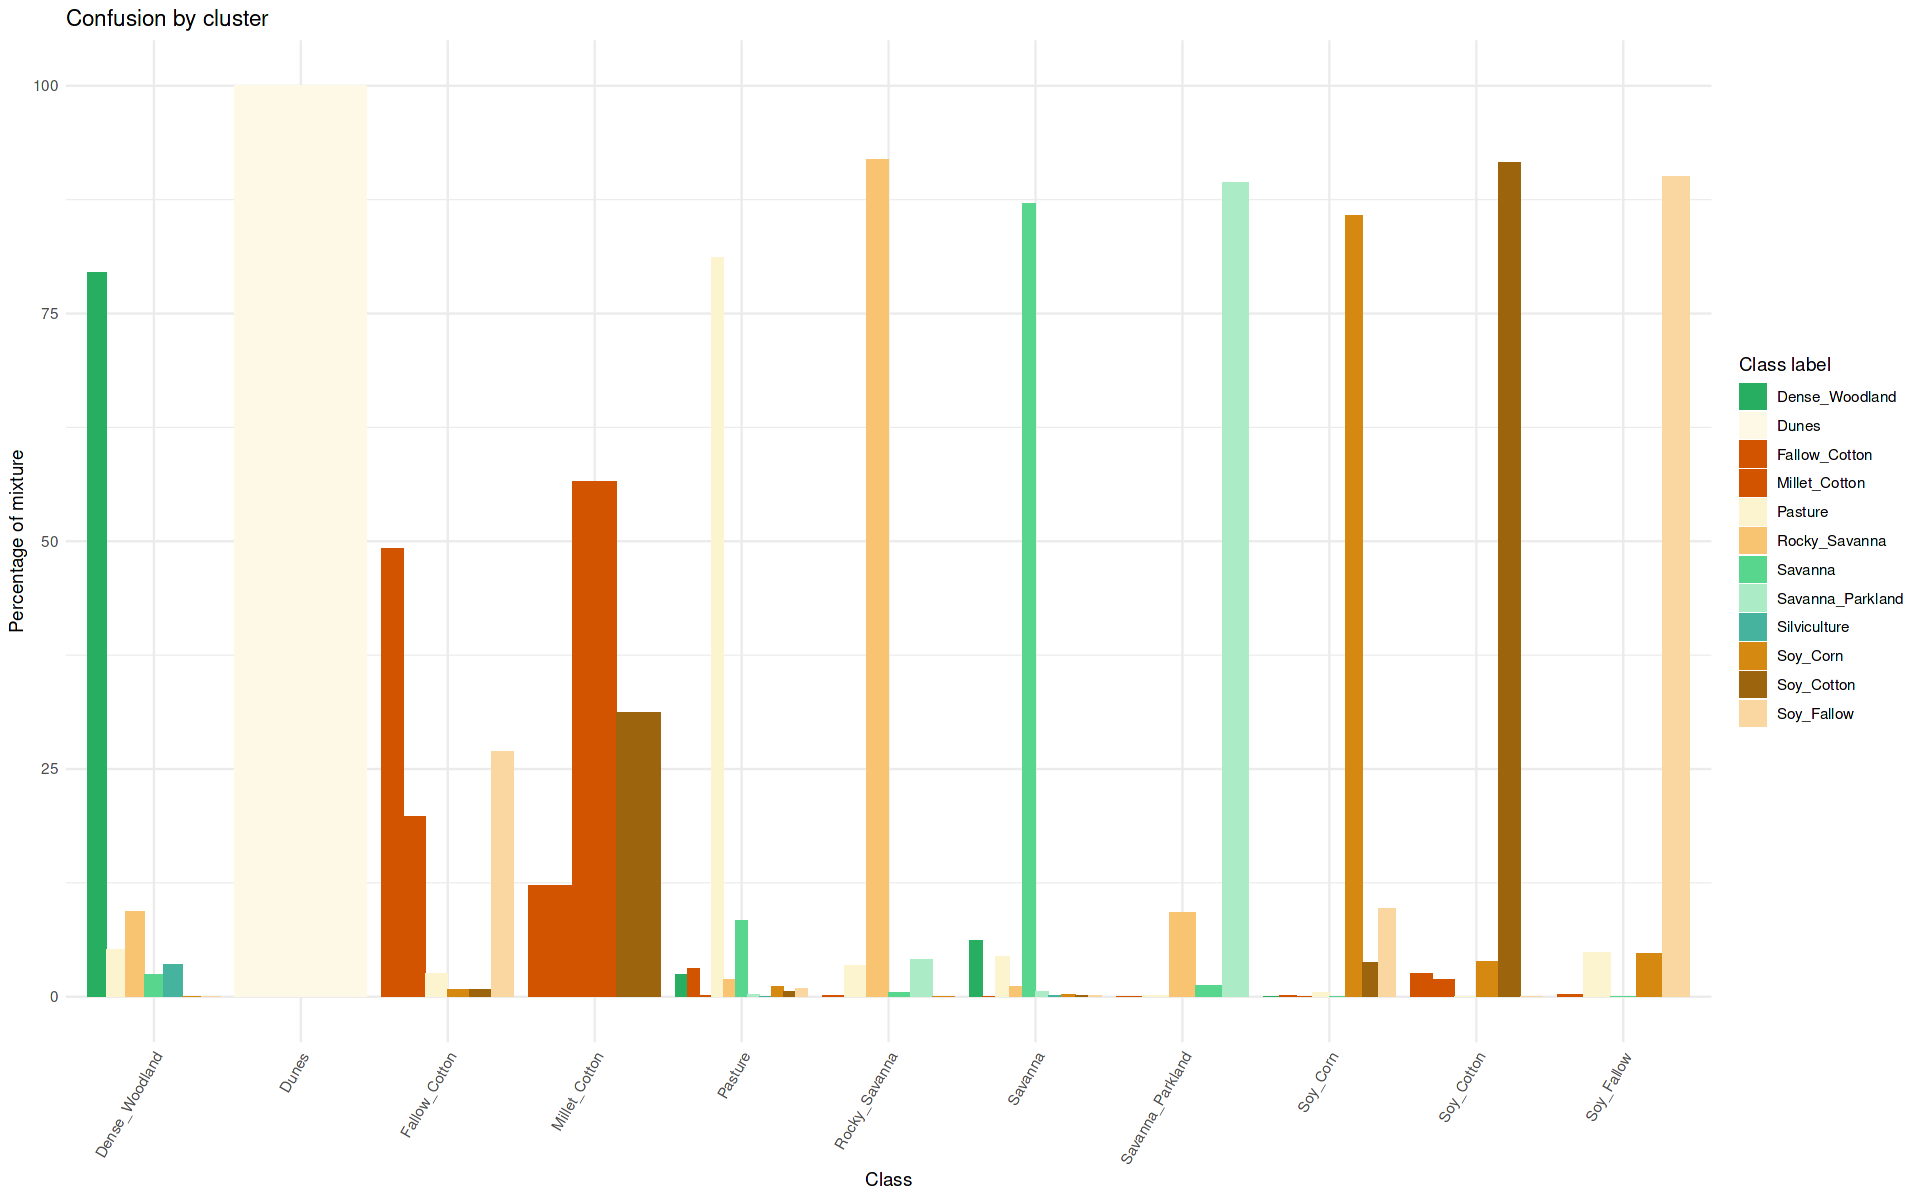

In [9]:
# The confusion by class can be visualised in a bar plot using `plot()`, as shown below. 
# The bar plot shows some confusion between the classes  "Savanna", "Savanna_Parkland", "Rocky_Savanna". 
# This mixture is due to the large variability of the natural vegetation of the Cerrado biome.
# Some confusion is also visible between the agricultural classes ("Soy_Corn", "Soy_Cotton" and "Soy_Fallow").
options(repr.plot.width = 16, repr.plot.height = 10)
plot(som_eval)

## Using probabilities to detect noisy samples
<hr style="border:1px solid #0077b9;">

The third step in the quality assessment uses the discrete probability distribution associated to each neuron. More homogeneous neurons (those with a single class of high probability) are assumed to be composed of good quality samples. Heterogeneous neurons (those with two or more classes with significant probability) are likely to contain noisy samples. The algorithm computes two values for each sample:

1. prior probability: the probability that the label assigned to the sample is correct, considering only the samples contained in each same neuron.  For example, if a neuron has 20 samples, of which 15 are labeled as "Pasture" and 5 as "Forest", all samples labeled "Forest" are assigned a prior probability of 25%. This is an indication that the "Forest" samples in this neuron are not of good quality.
2. posterior probability: the probability that the label assigned to the sample is correct, considering the neighboring neurons. Take the case of the above-mentioned neuron whose samples labeled "Pasture" have a prior probability of 75%. What happens if all the neighboring samples have "Forest" as a majority label? Are the samples labeled "Pasture" in this neuron noisy? To answer this question, we use information from the neighbors. Using Bayesian inference, we estimate if these samples are noisy based on the samples of the neighboring neurons. 

In [10]:
# The `sits_som_clean_samples()` function splits the samples in three groups:
# clean, noisy, analyze. The last category is samples which should be analysed by the user.

# It uses `prior_threshold` and `posterior_threshold` parameters: 
# (a) If the prior probability of a sample is less than `prior_threshold`, the sample is assumed to be noisy and tagged as "remove";
# (b) If the prior probability is greater or equal to `prior_threshold` 
#     and the posterior probability is greater or equal to `posterior_threshold`, the sample is "clean"; 
# (c) If the prior probability is greater or equal to `prior_threshold` 
#     and the posterior probability is less than `posterior_threshold`, this is an anomalous condition.
#    the sample is tagged as "analyze". Users are encouraged to inspect such samples.

# example of the function sits_som_clean_samples
new_samples <- sits_som_clean_samples(
    som_cluster, 
    prior_threshold = 0.6,
    posterior_threshold = 0.6,
    keep = c("clean", "analyze")
)

In [11]:
sits_labels_summary(new_samples)

label,count,prop
<chr>,<int>,<dbl>
Dense_Woodland,8585,0.21166695
Dunes,550,0.01356049
Pasture,5484,0.13521043
Rocky_Savanna,6224,0.15345546
Savanna,7752,0.19112897
Savanna_Parkland,2248,0.05542543
Soy_Corn,4633,0.11422865
Soy_Cotton,3785,0.09332084
Soy_Fallow,1298,0.03200276


In [12]:
# find out how many samples have been removed

cat(paste0("Original number of samples = ", nrow(samples_cerrado_mod13q1), "\n\n"))
cat(paste0("New number of samples = ", nrow(new_samples), "\n"))

Original number of samples = 50160

New number of samples = 40559


## Evaluating improvement in sample quality
<hr style="border:1px solid #0077b9;">

To compare the original and clean samples, we run a 4-fold validation on the original and on the cleaned sample set, using the function `sits_kfold_validate()` and a random forest model. The k-fold validation procedure measures how well the machine learning model fits the samples and is not a measure of accuracy of the classification.

<img src="https://brazil-data-cube.github.io/_images/k-folds.png" width="380" />

In [13]:
# use a random forest classifier to perform a 4-fold validation on the original samples
assess_orig <- sits_kfold_validate(
    samples_cerrado_mod13q1_2bands,
    folds = 4,
    ml_method = sits_rfor(num_trees = 200), 
    multicores = 4
)

# print summary 
sits_accuracy_summary(assess_orig)

Overall Statistics                            
 Accuracy : 0.9456          
   95% CI : (0.9435, 0.9475)
    Kappa : 0.9365          


In [14]:
# use a random forest classifier to perform a 4-fold validation on the original samples
assess_new <- sits_kfold_validate(
    new_samples, 
    folds = 4,
    ml_method = sits_rfor(num_trees = 200),
    multicores = 4
)

# print summary 
sits_accuracy_summary(assess_new)

Overall Statistics                            
 Accuracy : 0.9916          
   95% CI : (0.9907, 0.9925)
    Kappa : 0.9902          
